<a href="https://colab.research.google.com/github/ErickAlcaino/Proyectos/blob/main/Serie%20de%20Tiempo%20ARIMA/SerieTiempoCO2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Contexto

Se analizara la serie temporal CO2.csv, la cual representa la concentracion de CO2 de una ciudad en la india. El muestreo fue realizado desde el día 1/19/2018 a las 2am hasta el día
3/31/2023 a las 11 am con frecuencia de una hora. Se utiliza un modelo ARIMA en especifico primero en funcion de los graficos ACF y PACF y luego se emplea auto.arima para encontrar el mejor modelo.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pylab import rcParams
import statsmodels.api as sm
from astropy.timeseries import LombScargle
from scipy import stats
import pmdarima as pm


In [ ]:
def datainfo(data):
    temp_ps = pd.DataFrame(index=data.columns)
    temp_ps['DataType'] = data.dtypes
    temp_ps["Non-null_Values"] = data.count()
    temp_ps['Unique_Values'] = data.nunique()
    temp_ps['NaN_Values'] = data.isnull().sum()
    temp_ps['NaN_Values_Percentage'] = (temp_ps['NaN_Values']/len(data))*100
    return temp_ps


In [ ]:
# Cargar los datos
ozono = pd.read_csv('drive/MyDrive/Data/ozono.csv')

display(datainfo(ozono))

,DataType,Non-null_Values,Unique_Values,NaN_Values,NaN_Values_Percentage
From Date,object,45538,45538,0,0.000000
CO (mg/m3),float64,44866,458,672,1.475691


In [ ]:
display(ozono[ozono['CO (mg/m3)'].isnull()])

,From Date,CO (mg/m3)
266,1/30/2018 16:00,NaN
267,1/30/2018 17:00,NaN
268,1/30/2018 18:00,NaN
269,1/30/2018 19:00,NaN
270,1/30/2018 20:00,NaN
...,...,...
45255,3/20/2023 5:00,NaN
45256,3/20/2023 6:00,NaN
45257,3/20/2023 7:00,NaN
45258,3/20/2023 8:00,NaN


In [ ]:
ozono['From Date'] = pd.to_datetime(ozono['From Date'])
ozono.set_index('From Date', inplace=True)

# 3. Crear la serie de tiempo con la columna 'CO (mg/m3)'
ozono_series = ozono['CO (mg/m3)']

# Mostrar los primeros registros de la serie de tiempo
display(ozono_series.head())

,CO (mg/m3)
From Date,
2018-01-19 14:00:00,0.50
2018-01-19 15:00:00,0.46
2018-01-19 16:00:00,0.84
2018-01-19 17:00:00,0.95
2018-01-19 18:00:00,1.24


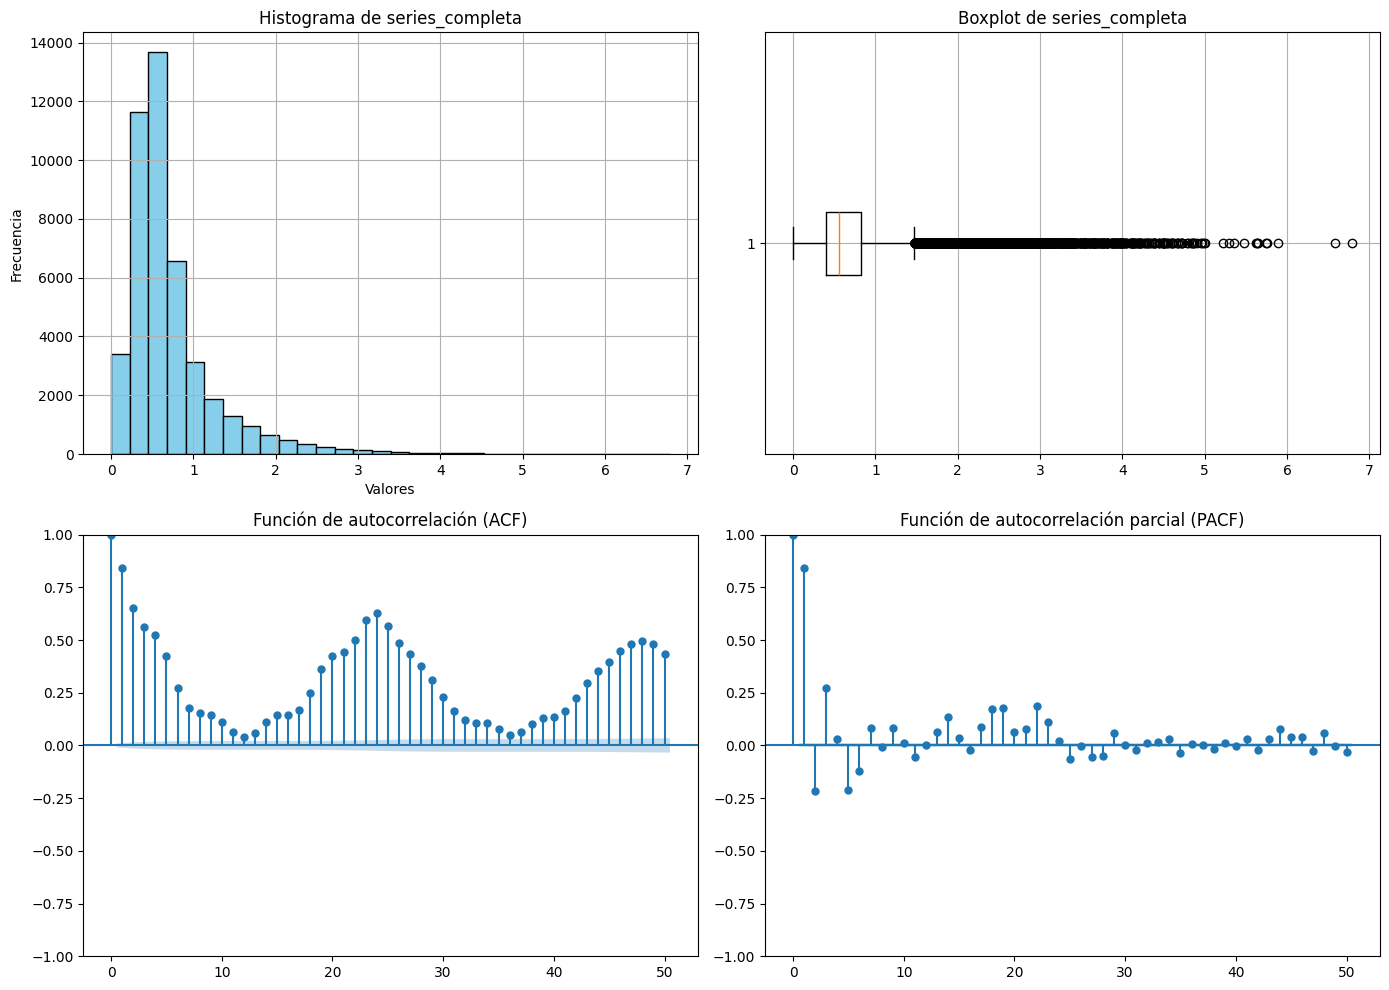

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Primer gráfico: Histograma
axs[0, 0].hist(ozono_series, bins=30, color='skyblue', edgecolor='black')
axs[0, 0].set_title('Histograma de series_completa')
axs[0, 0].set_xlabel('Valores')
axs[0, 0].set_ylabel('Frecuencia')
axs[0, 0].grid(True)

# Segundo gráfico: Boxplot
axs[0, 1].boxplot(ozono_series.dropna(), vert=False)
axs[0, 1].set_title('Boxplot de series_completa')
axs[0, 1].grid(True)

# Tercer gráfico: ACF
plot_acf(ozono_series.dropna(), lags=50, ax=axs[1, 0])
axs[1, 0].set_title('Función de autocorrelación (ACF)')

# Cuarto gráfico: PACF
plot_pacf(ozono_series.dropna(), lags=50, ax=axs[1, 1])
axs[1, 1].set_title('Función de autocorrelación parcial (PACF)')

# Ajustar el espacio entre los subplots
plt.tight_layout()
plt.show()

In [ ]:
#rellenar con los datos de 1 semana antes para mantener comportamiento.

ozono_completa = ozono_series.copy()
ozono_completa = ozono.fillna(ozono.shift(7*24))
ozono_completa = ozono_completa.fillna(ozono_completa.shift(7*24)) ## dos veces ya que quedaban 16 datos sin rellenar al hacerlo 1 vezx

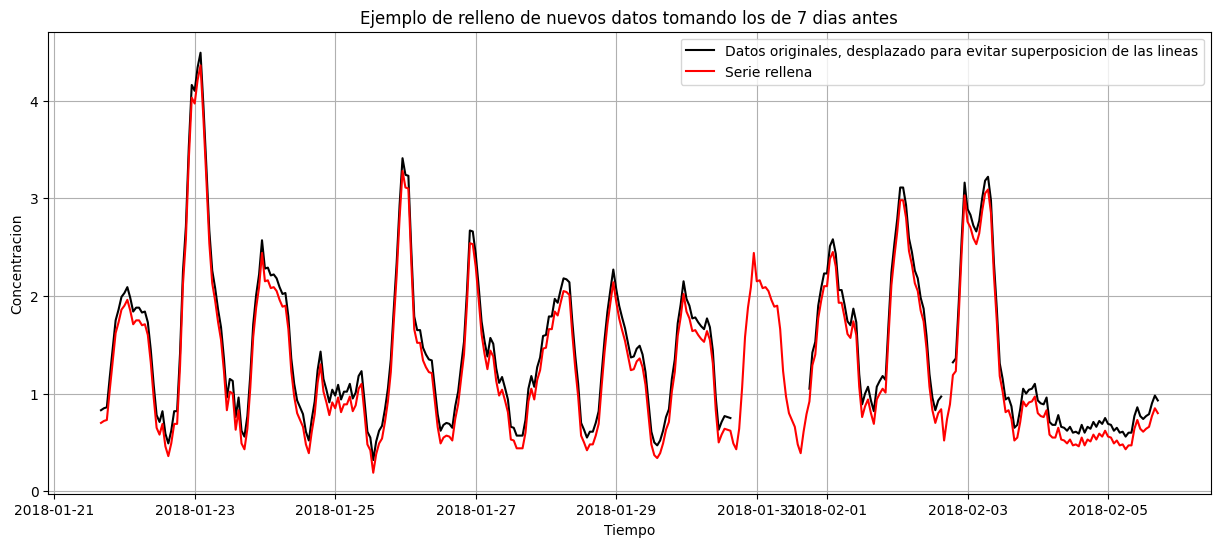

,DataType,Non-null_Values,Unique_Values,NaN_Values,NaN_Values_Percentage
CO (mg/m3),float64,45538,458,0,0.0


In [ ]:
# Graficar los datos reales y las predicciones
plt.figure(figsize=(15, 6))
plt.plot(ozono_series['1/21/2018 16:00':'2/5/2018 17:00']+0.13, label='Datos originales, desplazado para evitar superposicion de las lineas', color='black')
plt.plot(ozono_completa['1/21/2018 16:00':'2/5/2018 17:00'], label='Serie rellena', color='red')
plt.title('Ejemplo de relleno de nuevos datos tomando los de 7 dias antes')
plt.xlabel('Tiempo')
plt.ylabel('Concentracion')
plt.legend()
plt.grid(True)
plt.show()

display(datainfo(ozono_completa))

In [ ]:
#media_movil = ozono_completa.rolling(window=24, center=True).mean()
# Segunda aplicación de la media móvil
#for i in range(1,4):
  #media_movil = media_movil.rolling(window=24, center=True).mean()

#plt.figure(figsize=(16, 8))
#plt.plot(ozono_completa[-100:], label='Serie completa', color='blue')
#plt.plot(media_movil[-100:], label='1ta media movil', color='red')
#plt.title('Serie de Tiempo Ozono')
#plt.xlabel('Tiempo')
#plt.ylabel('Velocidad del Viento')
#plt.legend()
#plt.grid(True)
#plt.show()

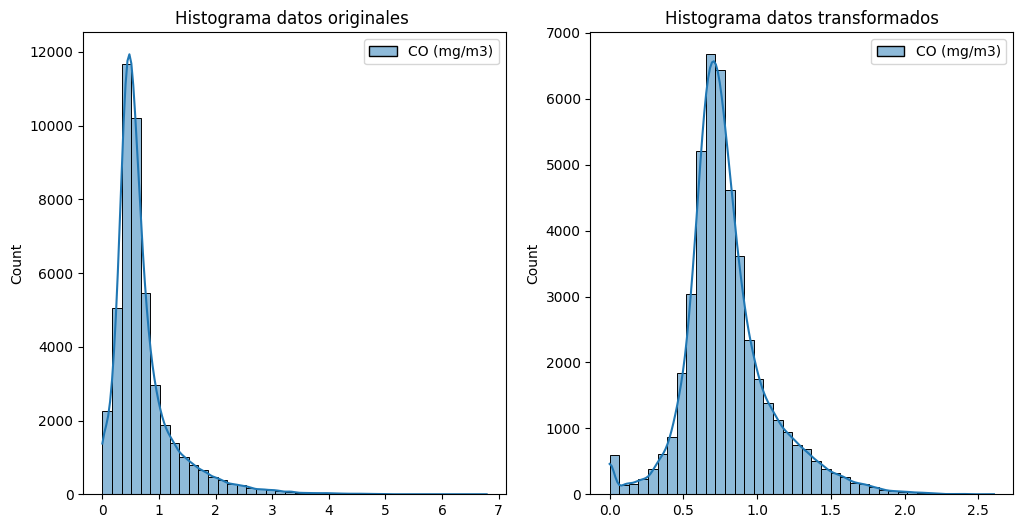

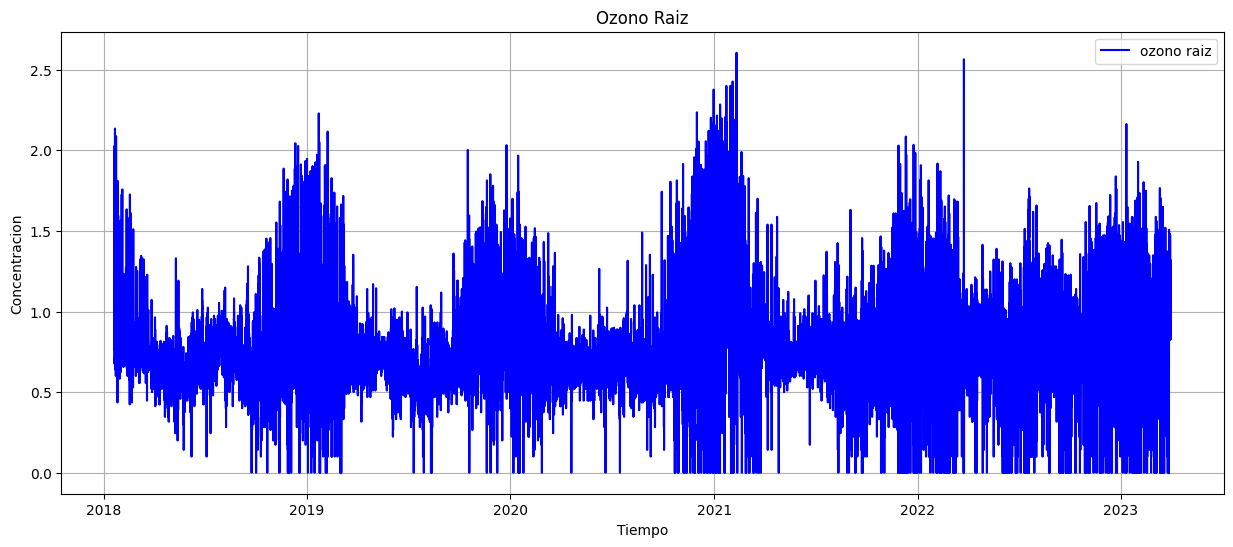

In [ ]:
ozono_raiz= np.power((ozono_completa),1/2)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(ozono_completa, bins=40, kde=True)
plt.title('Histograma datos originales ')
plt.subplot(1, 2, 2)
sns.histplot(ozono_raiz, bins=40, kde=True)
plt.title('Histograma datos transformados')
plt.show()

plt.figure(figsize=(15, 6))
plt.plot(ozono_raiz, label='ozono raiz', color='blue')
plt.title('Ozono Raiz')
plt.xlabel('Tiempo')
plt.ylabel('Concentracion')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
num_rows = len(ozono_raiz)
last_10 = int(num_rows * 0.9)
last_8 = int(num_rows * 0.8)
# Get the index value at the desired position
last_8_index = ozono_raiz.index[last_8]
last_10_index = ozono_raiz.index[last_10]

# Use the index value for slicing
SerieUltimo10 = ozono_raiz.loc[last_8_index:last_10_index]

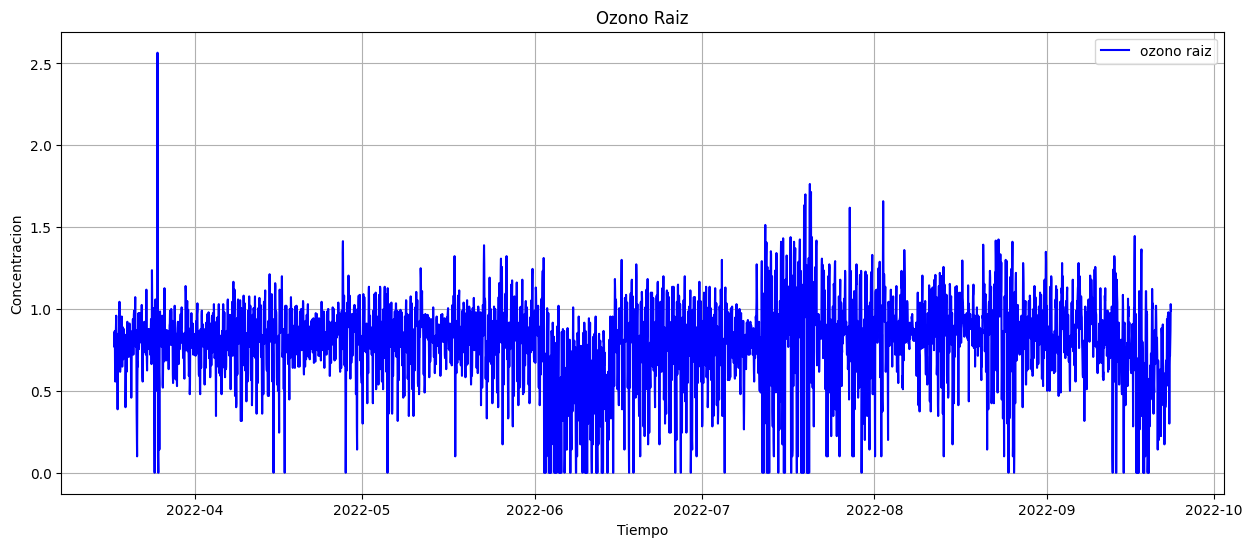

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(SerieUltimo10, label='ozono raiz', color='blue')
plt.title('Ozono Raiz')
plt.xlabel('Tiempo')
plt.ylabel('Concentracion')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
modelo_hw = ExponentialSmoothing(SerieUltimo10,
                                 trend='add',      # tendencia aditiva
                                 seasonal='add',   # estacionalidad aditiva
                                 seasonal_periods=24).fit()  # ajusta el modelo

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


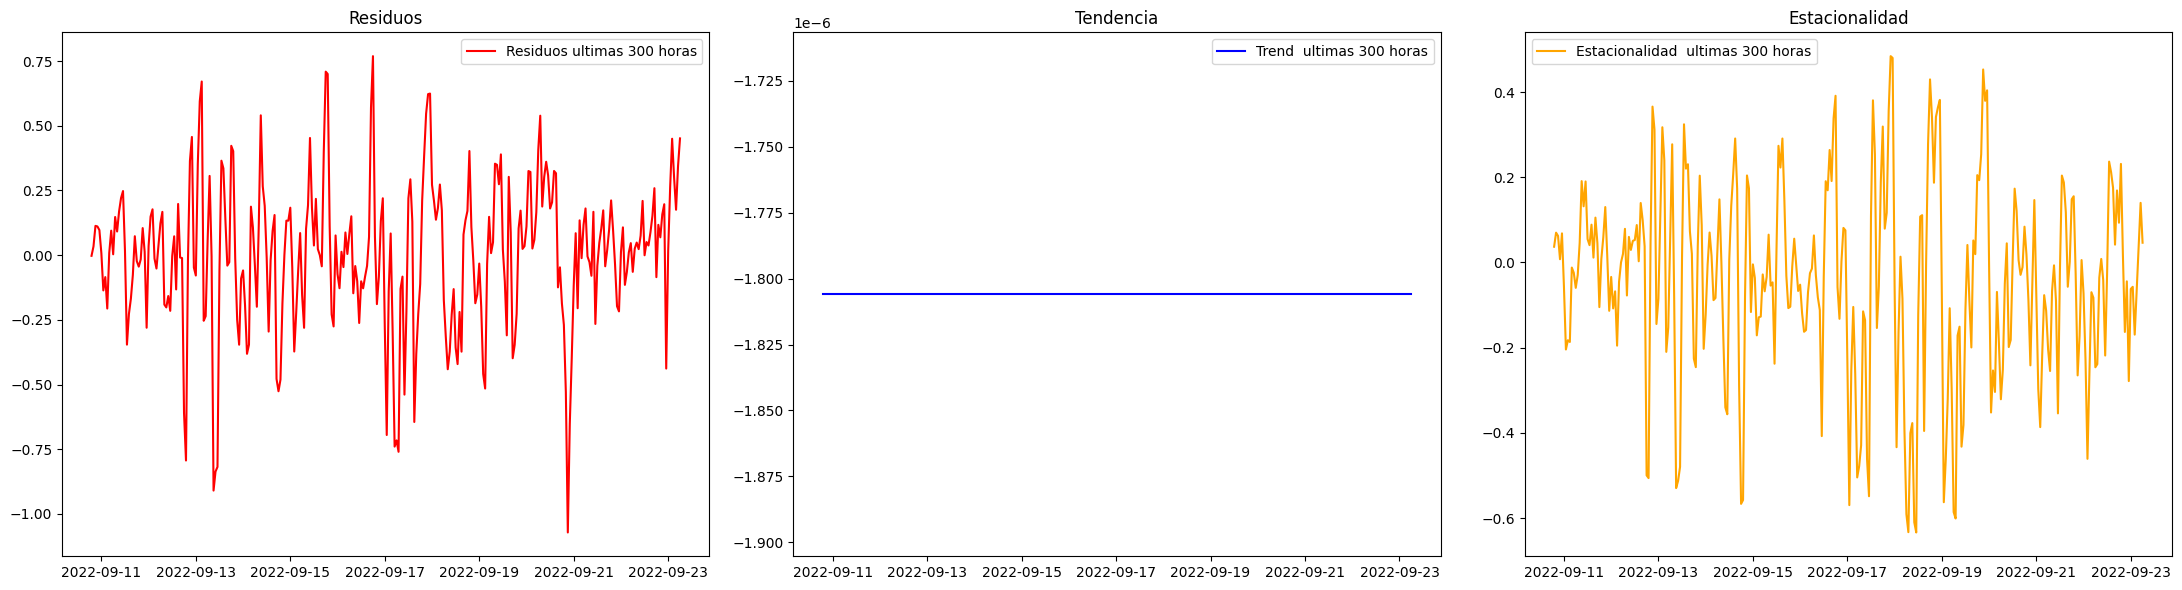

In [ ]:
plt.figure(figsize=(22, 6))

# Primer gráfico: Residuos
plt.subplot(1, 3, 1)  # 1 fila, 3 columnas, primer gráfico
plt.plot(modelo_hw.resid[-300:], label='Residuos ultimas 300 horas', color='red')
plt.legend()
plt.title('Residuos')


# Segundo gráfico: Tendencia
plt.subplot(1, 3, 2)  # 1 fila, 3 columnas, segundo gráfico
plt.plot(modelo_hw.trend[-300:], label='Trend  ultimas 300 horas', color='blue')
plt.legend()
plt.title('Tendencia')

# Tercer gráfico: Estacionalidad
plt.subplot(1, 3, 3)  # 1 fila, 3 columnas, tercer gráfico
plt.plot(modelo_hw.season[-300:], label='Estacionalidad  ultimas 300 horas', color='orange')
plt.legend()
plt.title('Estacionalidad')

# Mostrar la figura con los 3 gráficos en una fila
plt.tight_layout()  # Ajusta el espaciado entre los gráficos
plt.show()

In [ ]:
values_SerieUltimo10 = SerieUltimo10.values.flatten()
values_season = modelo_hw.season.values
Serie_values = []

for i in range(min(len(values_SerieUltimo10), len(values_season))):
    result = values_SerieUltimo10[i] - values_season[i]
    Serie_values.append(result)


#Serie = pd.Series(Serie_values, index=SerieUltimo10.index)

Serie=SerieUltimo10

In [ ]:
adf = adfuller(Serie)
print(f'ADF Statistic: {adf[0]}')
print(f'p-value : {adf[1]}')
print(f'Critical Values : {adf[4]}')

from statsmodels.tsa.stattools import kpss

result = kpss(Serie, regression='c')
print("\n\n KPSS Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[3],'\n')

ADF Statistic: -4.663882043644252
p-value : 9.83305474077838e-05
Critical Values : {'1%': -3.4317959698326304, '5%': -2.8621789475461004, '10%': -2.567110115088062}


 KPSS Statistic: 0.6714911348841012
p-value: 0.016137169555990802
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739} 



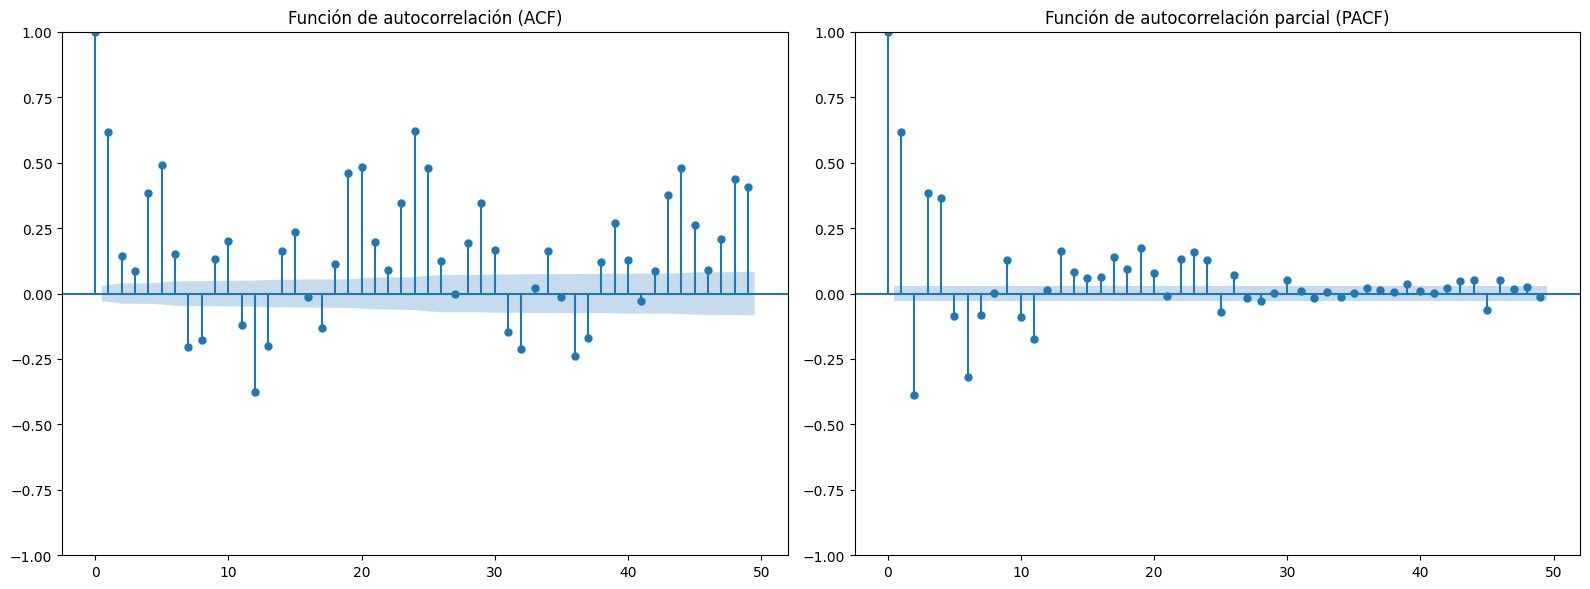

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Graficar la ACF en el primer subplot (izquierda)
plot_acf(Serie, lags=49, ax=axes[0])
axes[0].set_title('Función de autocorrelación (ACF)')

# Graficar la PACF en el segundo subplot (derecha)
plot_pacf(Serie, lags=49, ax=axes[1])
axes[1].set_title('Función de autocorrelación parcial (PACF)')

# Mostrar las gráficas
plt.tight_layout()
plt.show()

In [ ]:
model = ARIMA(Serie, order=(4, 0,4))
model_fit = model.fit()
model_fit.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             CO (mg/m3)   No. Observations:                 4555
Model:                 ARIMA(4, 0, 4)   Log Likelihood                2289.093
Date:                Thu, 07 Nov 2024   AIC                          -4558.187
Time:                        02:13:44   BIC                          -4493.947
Sample:                    03-17-2022   HQIC                         -4535.565
                         - 09-23-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7955      0.009     85.448      0.000       0.777       0.814
ar.L1          0.9305      6.326      0.147      0.883     -11.467      13.328
ar.L2         -0.8850      8.348     -0.106      0.916     -17.246      15.476
ar.L3          0.2185      8.857      0.025      0.980     -17.140      17.577
ar.L4          0.2989      4.834      0.062      0.951      -9.175       9.773
ma.L1         -0.0964      6.325     -0.015      0.988     -12.493      12.300
ma.L2          0.5946      3.069      0.194      0.846      -5.421       6.610
ma.L3          0.2998      4.966      0.060      0.952      -9.434      10.034
ma.L4         -0.0046      0.040     -0.114      0.909      -0.084       0.074
sigma2         0.0214      0.000    106.884      0.000       0.021       0.022
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             18011.50
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               2.17   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

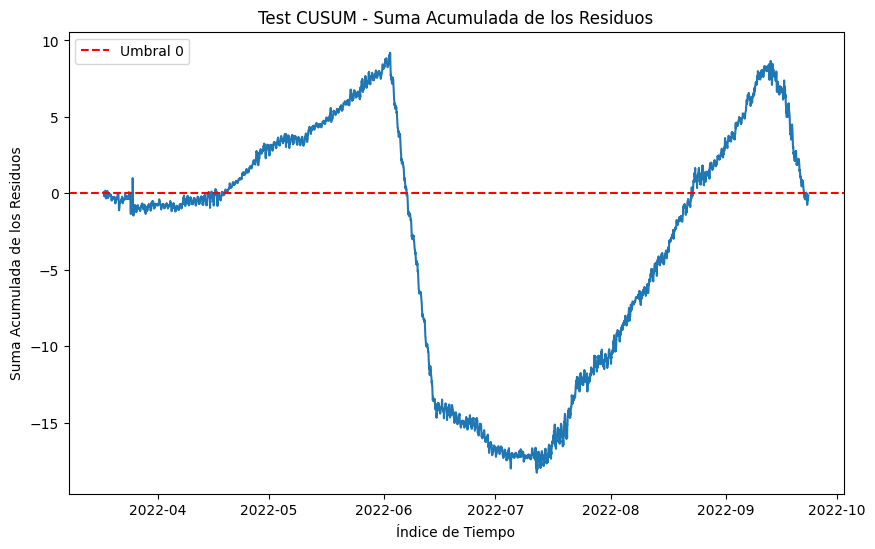

In [ ]:
suma_acumulada = np.cumsum(model_fit.resid)

# Graficar la suma acumulada de los residuos
plt.figure(figsize=(10, 6))
plt.plot(suma_acumulada)
plt.axhline(y=0, color='red', linestyle='--', label='Umbral 0')
plt.title('Test CUSUM - Suma Acumulada de los Residuos')
plt.xlabel('Índice de Tiempo')
plt.ylabel('Suma Acumulada de los Residuos')
plt.legend()
plt.show()

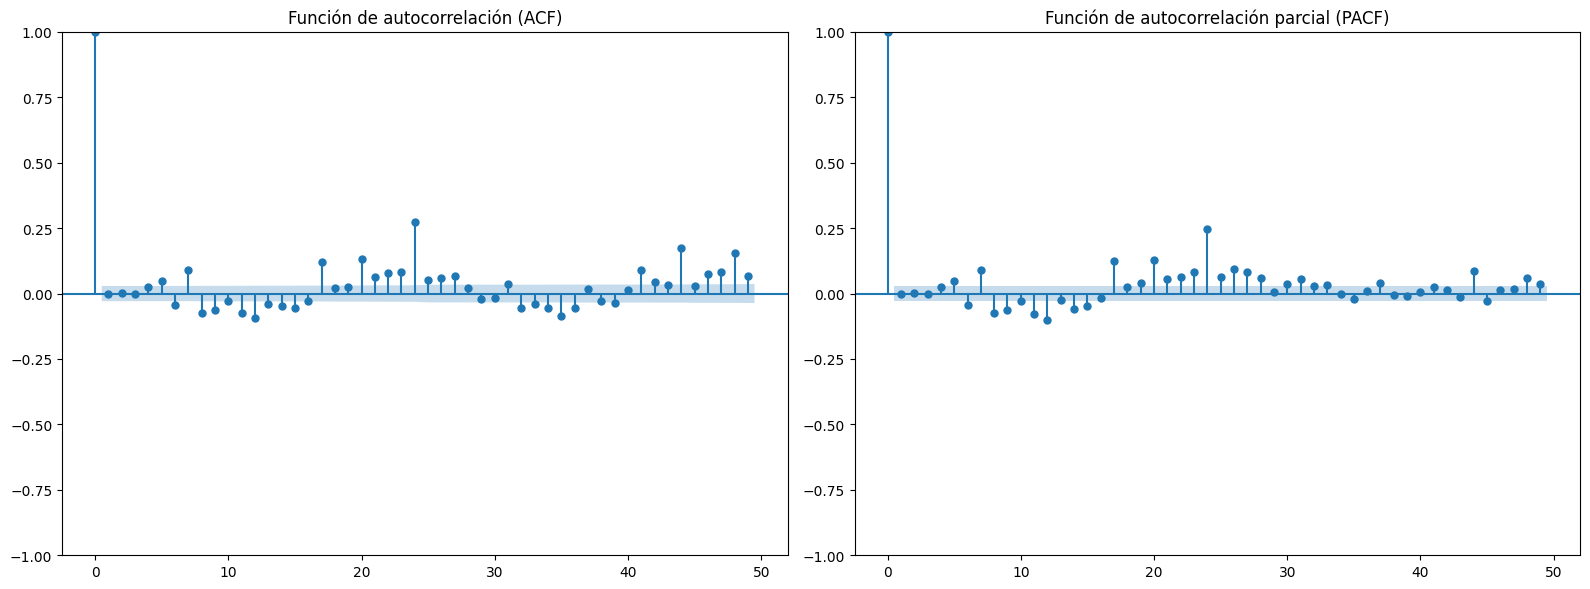

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Graficar la ACF en el primer subplot (izquierda)
plot_acf(model_fit.resid, lags=49, ax=axes[0])
axes[0].set_title('Función de autocorrelación (ACF)')

# Graficar la PACF en el segundo subplot (derecha)
plot_pacf(model_fit.resid, lags=49, ax=axes[1])
axes[1].set_title('Función de autocorrelación parcial (PACF)')

# Mostrar las gráficas
plt.tight_layout()
plt.show()

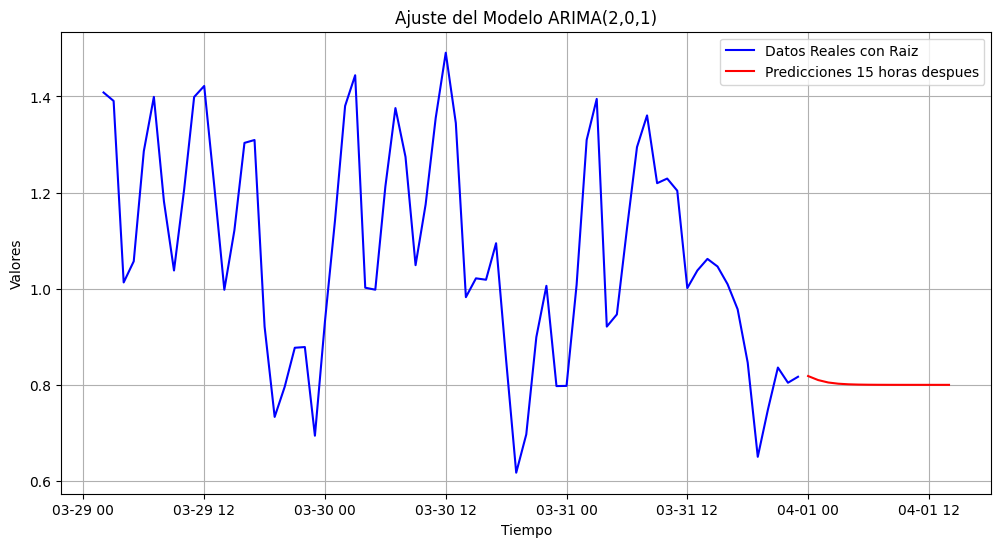

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(Serie[-70:], label='Datos Reales con Raiz ', color='blue')
plt.plot(model_fit.forecast(steps=15), label='Predicciones 15 horas despues', color='red')
plt.title('Ajuste del Modelo ARIMA(2,0,1)')
plt.xlabel('Tiempo')
plt.ylabel('Valores')
plt.legend()
plt.grid(True)
plt.show()

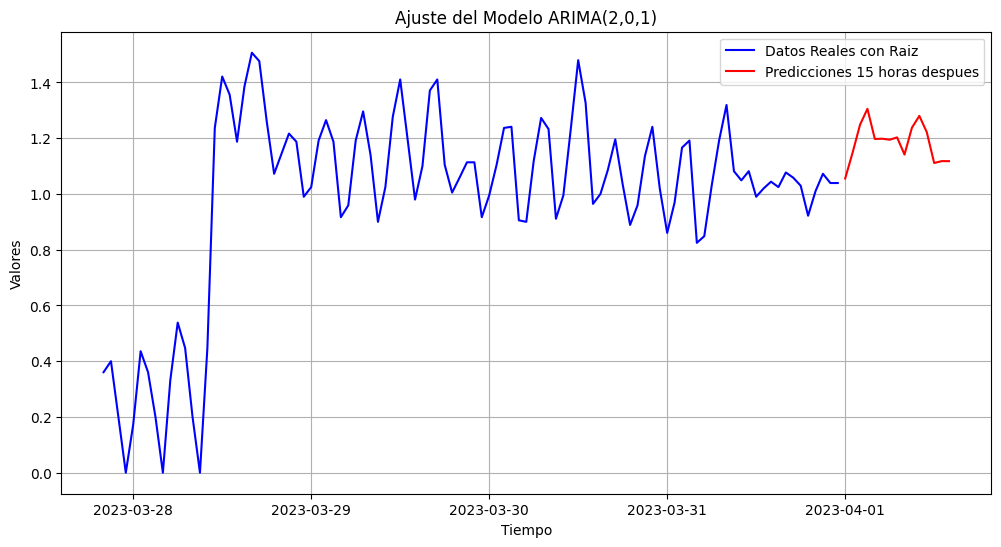

In [ ]:
pred_hw_arima =  model_fit.forecast(steps=15)

values_pred_hw_arima = pred_hw_arima.values.flatten()
values_season = modelo_hw.season[-24:-9].values

predicciones_values = []

# Iterate through the values and perform the subtraction
for i in range(min(len(pred_hw_arima), len(values_season))):
    result = values_pred_hw_arima[i] - values_season[i]
    predicciones_values.append(result)

predicciones = pd.Series(predicciones_values, index=pred_hw_arima.index)+0.3

plt.figure(figsize=(12, 6))
plt.plot(SerieUltimo10[-100:], label='Datos Reales con Raiz ', color='blue')
plt.plot(predicciones, label='Predicciones 15 horas despues', color='red')
plt.title('Ajuste del Modelo ARIMA(2,0,1)')
plt.xlabel('Tiempo')
plt.ylabel('Valores')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:


pm.arima.ndiffs(Serie, test='adf')

0

In [ ]:
from pmdarima import auto_arima

# Ajuste de la serie con auto_arima
modelo_auto_arima = auto_arima(Serie, seasonal=False,  # `m=24` para estacionalidad diaria en series horarias
                               trace=True,                  # Imprime resultados de cada modelo probado
                               error_action='ignore',       # Ignora errores y continúa
                               suppress_warnings=True,      # Suprime advertencias
                               stepwise=True)               # Prueba modelos de manera eficiente

# Ver los parámetros del mejor modelo
print(modelo_auto_arima.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4055.220, Time=9.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-722.062, Time=0.42 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-787.870, Time=0.29 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1010.624, Time=1.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-724.062, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2664.796, Time=8.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-3156.568, Time=5.92 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-4112.665, Time=9.19 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-3552.185, Time=4.82 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-4146.077, Time=15.33 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-3596.528, Time=7.76 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=-4142.169, Time=14.97 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-4133.248, Time=16.46 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-4052.770, Time=14.56 sec
 ARIMA(5,1,1)(0,0,

KeyboardInterrupt: 